In [2]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Paths to the datasets and outputs
# Directory to save the images
IMAGE_DIR = "../reports/visualizations"
os.makedirs(IMAGE_DIR, exist_ok=True)  # Create the directory if it doesn't exist

# Paths to the datasets
TRAIN_PATH = ('../data/raw/Training')
TEST_PATH = ('../data/raw/Testing')


### Load data and get metadata

In [5]:

def get_metadata(path, data_type):
    """
    Extracts metadata from images in a specified directory and returns a DataFrame.

    Args:
        path (str): The file path to the directory containing subdirectories of images.
        data_type (str): A label representing the type of data (e.g., 'train', 'test').

    Returns:
        pd.DataFrame: A DataFrame containing the metadata of the images including
                      paths, sizes, areas, labels, and data types.
    """
    data = []

    # Iterate over each category (subdirectory)
    for category in os.listdir(path):
        category_path = os.path.join(path, category)

        # Iterate over each image in the category
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)

            # Skip if image is not found
            if image is None:
                continue

            original_size = image.shape
            area = original_size[0] * original_size[1]

            # Append metadata to the list
            data.append({
                'Path': image_path,
                'Data': data_type,
                'Label': category,
                'Original_Size': original_size,
                'Area': area
            })

    return pd.DataFrame(data)

# Process each dataset and create DataFrames
train_df = get_metadata(TRAIN_PATH, 'train')
test_df = get_metadata(TEST_PATH, 'test')

# Combine the DataFrames
df = pd.concat([train_df, test_df], ignore_index=True)
# Optionally, save the DataFrame to a CSV file
df.to_csv('../reports/image_sizes_labels_and_data.csv', index=False)

df.head()

,Path,Data,Label,Original_Size,Area
0,../data/raw/Training/pituitary/Tr-pi_0505.jpg,train,pituitary,"(512, 512, 3)",262144
1,../data/raw/Training/pituitary/Tr-pi_0263.jpg,train,pituitary,"(512, 512, 3)",262144
2,../data/raw/Training/pituitary/Tr-pi_0277.jpg,train,pituitary,"(512, 512, 3)",262144
3,../data/raw/Training/pituitary/Tr-pi_1169.jpg,train,pituitary,"(512, 512, 3)",262144
4,../data/raw/Training/pituitary/Tr-pi_0511.jpg,train,pituitary,"(512, 512, 3)",262144


### EDA

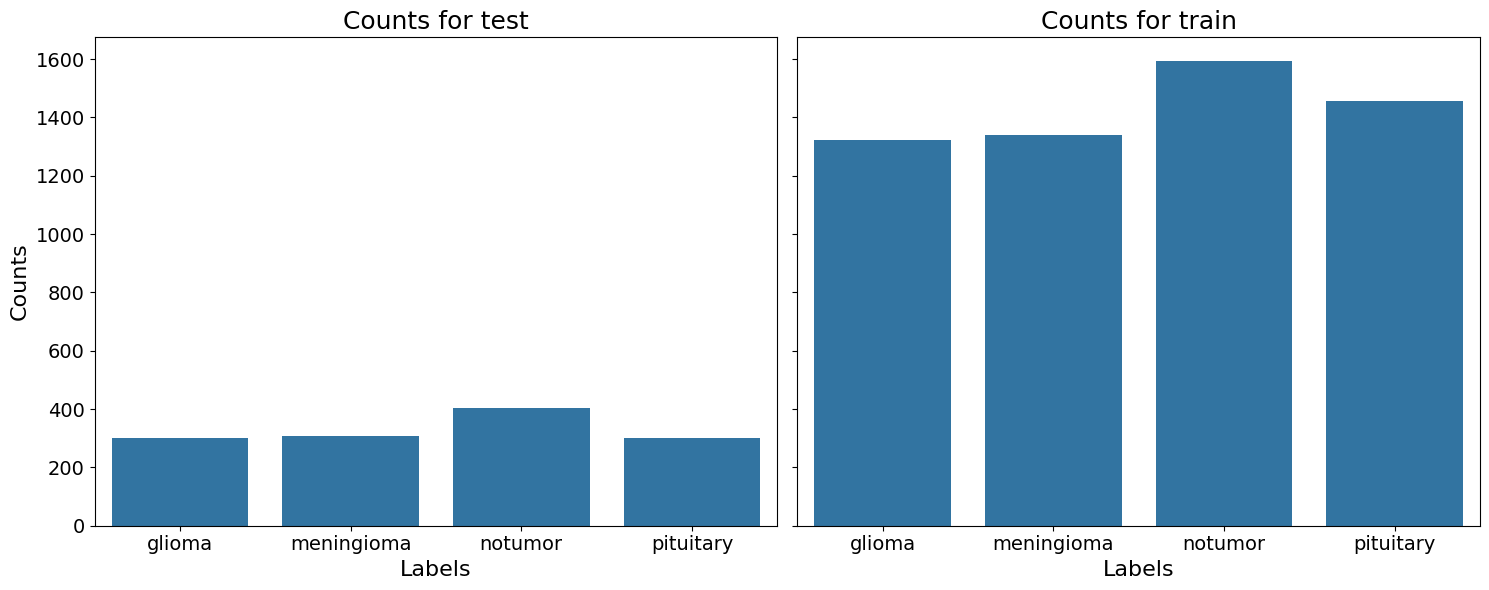

In [6]:
# Get the counts
grouped_counts = df.groupby('Data')['Label'].value_counts().unstack(0)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for each category in 'Data'
for i, (data_category, counts) in enumerate(grouped_counts.items()):
    sns.barplot(ax=axes[i], x=counts.index, y=counts.values)
    axes[i].set_title(f'Counts for {data_category}', fontsize=18)
    axes[i].set_xlabel('Labels', fontsize=16)
    axes[i].set_ylabel('Counts', fontsize=16)
    axes[i].tick_params(labelsize=14)

# Adjust layout
plt.tight_layout()

# Save the plot to a file
plt.savefig(os.path.join(IMAGE_DIR, 'label_counts_barplot.png'))

# Show the plot
plt.show()


<Axes: xlabel='Area', ylabel='Density'>

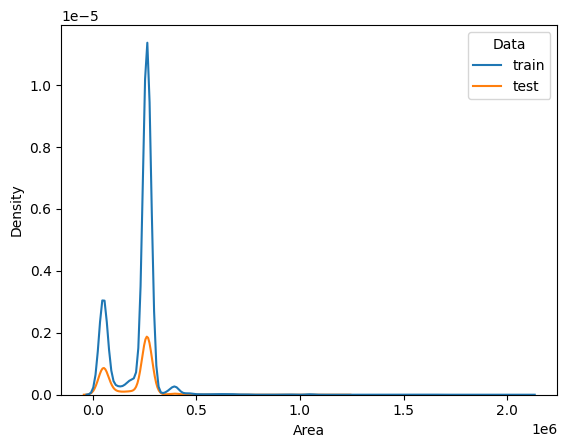

In [7]:
# Plot the histogram of the areas for train and test
sns.kdeplot(data=df, x='Area', hue='Data', log_scale=False)


In [8]:
# Describe the areas for train and test sets separately without log scale, as integers
df.groupby(['Data', 'Label'])['Area'].describe().astype(int)


count    mean     std     min     25%     50%     75%  \
Data  Label                                                               
test  glioma        300  262144       0  262144  262144  262144  262144   
      meningioma    306  209730  105381   40020  122492  262144  262144   
      notumor       405   88348   82973   29700   50388   50625   63720   
      pituitary     300  259522   22588   65536  262144  262144  262144   
train glioma       1321  262144       0  262144  262144  262144  262144   
      meningioma   1339  249646   73383   39240  262144  262144  262144   
      notumor      1595  124770  154623   29700   50388   50625  168744   
      pituitary    1457  261430   65343   40804  262144  262144  262144   

                      max  
Data  Label                
test  glioma       262144  
      meningioma  1170831  
      notumor      462400  
      pituitary    262144  
train glioma       262144  
      meningioma  1819425  
      notumor     2073600  
      pituitary   1863225

Axes(0.125,0.11;0.352273x0.167391)


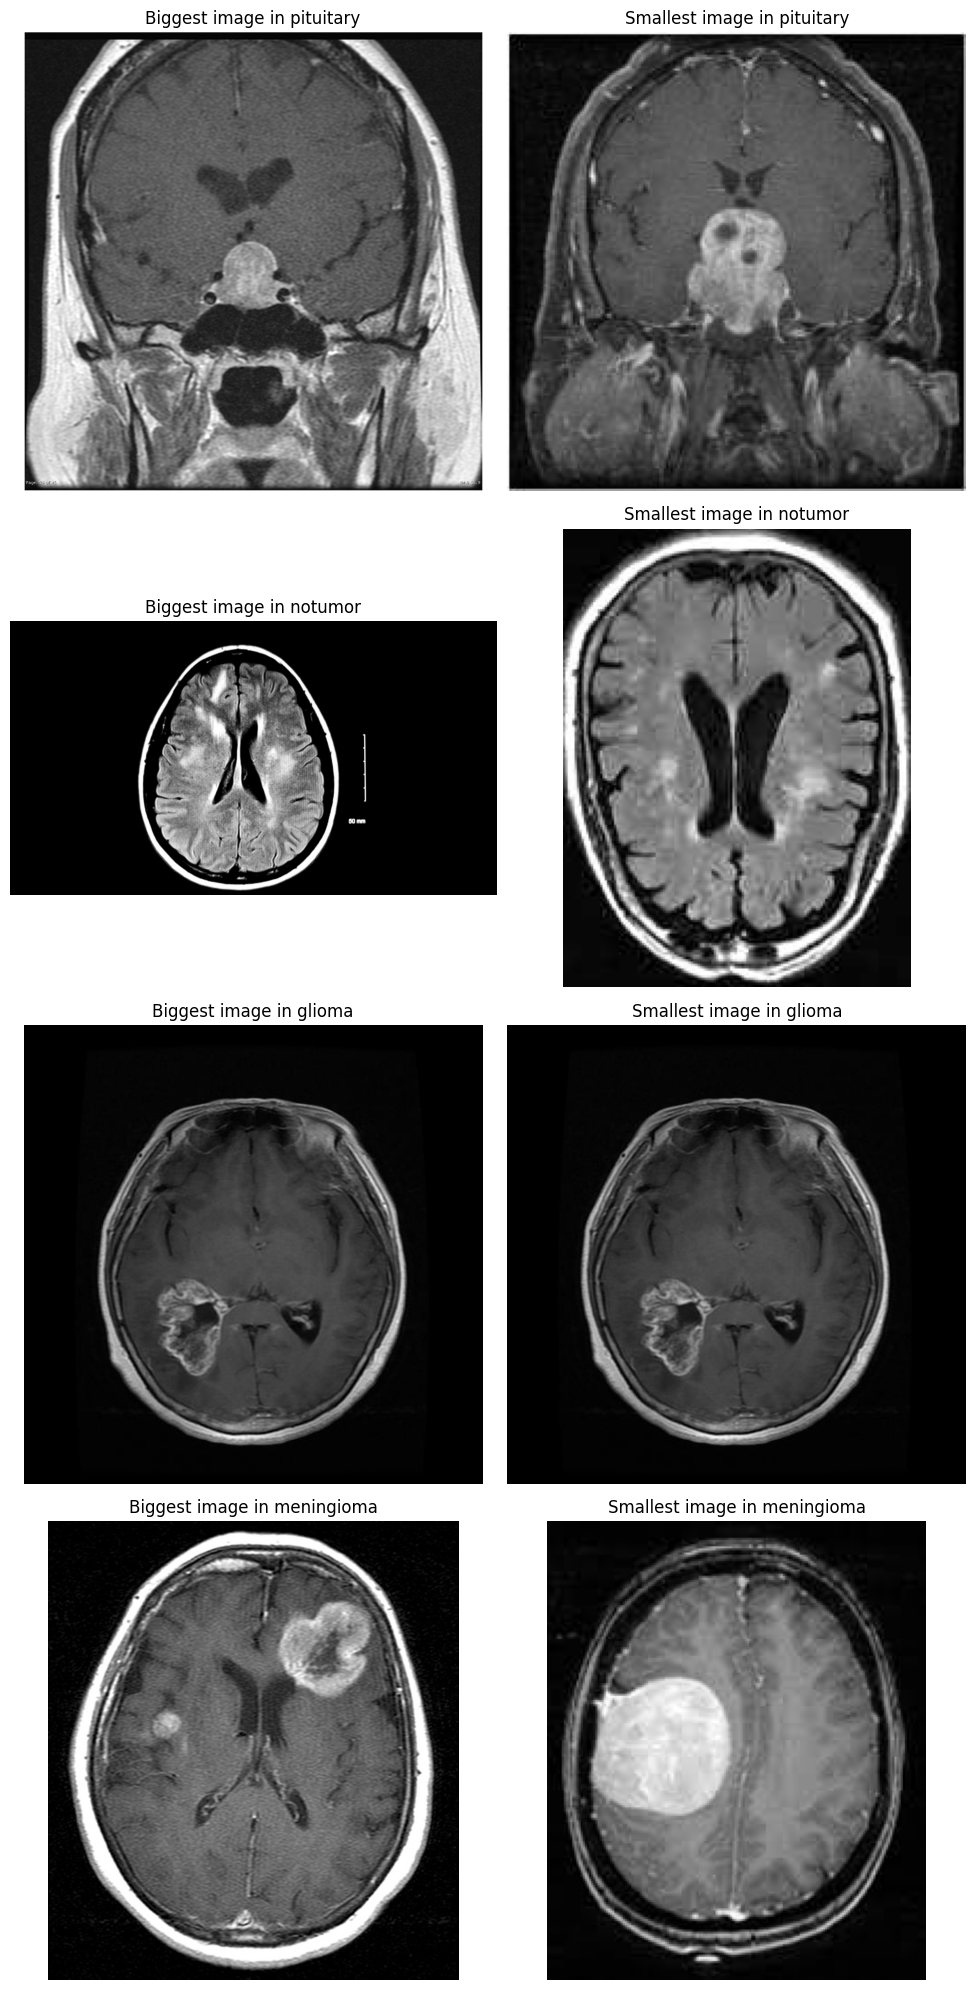

In [10]:
def display_image(image_path, title, ax):
    """
    Display an image using Matplotlib.

    This function reads an image from the specified file path, and then displays it 
    on a given Matplotlib Axes object. The image is displayed with the provided title 
    and with axis lines turned off.

    Args:
        image_path (str): Path to the image file to be displayed.
        title (str): Title to be set for the subplot.
        ax (matplotlib.axes.Axes): The Axes object in which the image will be displayed.

    Returns:
        None
    """
    image = cv2.imread(image_path)
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

# Group the DataFrame by 'Label' and find the indices of max and min areas
max_area_indices = df.groupby('Label')['Area'].idxmax()
min_area_indices = df.groupby('Label')['Area'].idxmin()

# Number of unique labels
num_labels = df['Label'].nunique()

# Create subplots - two columns for each label (biggest and smallest)
fig, axes = plt.subplots(num_labels, 2, figsize=(10, 5 * num_labels))
print(axes[i, 0])
for i, label in enumerate(df['Label'].unique()):
    # Get the path of the image with the biggest area for this label
    biggest_image_path = df.loc[max_area_indices[label], 'Path']
    # Get the path of the image with the smallest area for this label
    smallest_image_path = df.loc[min_area_indices[label], 'Path']

    # Display the biggest image
    display_image(biggest_image_path, f"Biggest image in {label}", axes[i, 0])
    # Display the smallest image
    display_image(smallest_image_path, f"Smallest image in {label}", axes[i, 1])

plt.tight_layout()
plt.savefig('../reports/visualizations/biggest_and_smallest_images_by_label.jpg')
plt.show()